<a href="https://colab.research.google.com/github/HelloWorld33333/Pork/blob/main/AI_07_%EB%B0%95%ED%83%9C%EA%B7%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


> 발표자

코드스테이츠 AI 7기 박태균


목적 : 우리는 어떤 게임을 만들어야 하는가


---





# **1. 목차**

*   게임 트렌드 분석
*   인기 게임 분석
*   게임 시장 전망 예측
*   결론

In [ ]:
from google.colab import files
file_uploaded = files.upload()

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 예시 데이터를 기반으로 최근 게임의 트렌드 윤곽을 잡고 게임 시장은 전망을 예측하여 목표에 대해 적합한 게임을 만드는 것이 목적입니다.

from datetime import datetime

import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# 시장가와 판매량을 대조해 Sales가 나타내는 값이 0.01당 1만이라는 결론을 내렸습니다.
def sales_unity(data):
  if "M" in data:
    return float(data.replace("M", ""))

  elif "K" in data:
    return float(data.replace("K", ""))*0.01

  else : return data

df = pd.read_csv(io.BytesIO(file_uploaded['vgames2.csv']))
#df.dtypes
#df

df_na = df.loc[:, 'NA_Sales'].apply(sales_unity)
df_eu = df.loc[:, 'EU_Sales'].apply(sales_unity)
df_jp = df.loc[:, 'JP_Sales'].apply(sales_unity)
df_os = df.loc[:, 'Other_Sales'].apply(sales_unity)

df_s = pd.concat([df_na, df_eu, df_jp, df_os], axis=1)
df_s = df_s.astype(float)*100
df_s = df_s.astype(int)

def year_unity(data):
  if data < 1900 : 
    if data < 20 :
      return data + 2000
    else :
      return data + 1900
  else : return data

df['Year'].value_counts()

# 출시 년도가 정확히 언제인지 모르는 게임은 1980~2020 사이 평균값인 2000로 대체하였습니다.
df_y = pd.DataFrame(df['Year'].fillna(2000).apply(year_unity).astype('int'))
#df_y.isnull().sum()

# 장르가 불분명 한 게임은 기타 게임을 나타내는 Misc로 대체하였습니다.
df_g = pd.DataFrame(df['Genre'].fillna('Misc'))


df_t = pd.DataFrame(df_s['NA_Sales'] + df_s['EU_Sales'] + df_s['JP_Sales'] + df_s['Other_Sales'])
df_t.columns = ['Total_Sales']

df_EDA = pd.concat([df.loc[:, 'Name':'Platform'], df_y, df_g, df['Publisher'], df_s, df_t], axis=1)


df_EDA_kor = df_EDA
df_EDA_kor.columns = ['게임 이름', '플랫폼', '출시 년도', '장르', '퍼블리셔(제작사)', '북미 출고량(단위:1만장)', '유럽 출고량(단위:1만장)', '일본 출고량(단위:1만장)', '기타 지역 출고량(단위:1만장)', '총합 출고량(단위:1만장)']
df_EDA_kor.head(20)


# **2. 게임 트렌드 분석**

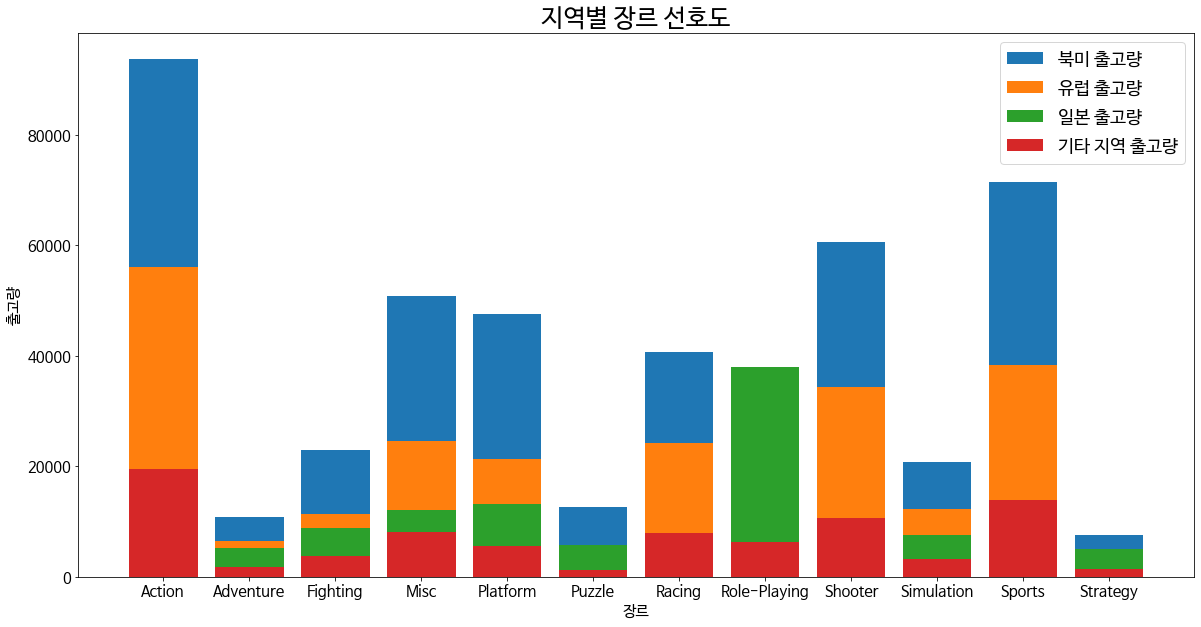

In [170]:
# 지역에 따라 선호하는 장르가 정말 다를까
# 지역별 출고된 게임의 장르의 빈도 수 비교해서 출고량이 가장 많은 장르를 지역별 선호하는 장르로 선정했습니다.

def top3_genre(df, sales_loc):
    loc_genre = df.loc[:, ['장르', sales_loc]].sort_values(by=sales_loc, ascending=False).reset_index(drop=True).head(3)
    loc_genre.columns = ['장르', '출고량']
    return loc_genre

genre_gourp = pd.concat([df_g, df_s], axis=1)

genre_gourp = genre_gourp.groupby(['Genre']).sum().reset_index()

genre_gourp.head()

plt.figure(figsize=(20, 10))
plt.title('지역별 장르 선호도', loc='center', fontsize=25)

plt.xlabel('장르', fontsize=15)
plt.ylabel('출고량', fontsize=15)


plt.bar(genre_gourp['Genre'], genre_gourp['NA_Sales'])
plt.bar(genre_gourp['Genre'], genre_gourp['EU_Sales'])
plt.bar(genre_gourp['Genre'], genre_gourp['JP_Sales'])
plt.bar(genre_gourp['Genre'], genre_gourp['Other_Sales'])

plt.legend(['북미 출고량', '유럽 출고량', '일본 출고량', '기타 지역 출고량'], fontsize=18)

plt.show()


# 우리가 먼저 1차적으로 알아볼 것은 최근 게임의 트렌드 입니다.
# 게임 트렌드란 말 그대로 유행을 뜻하며 이는 지역별로 상이하게 다를 수 있기 때문에 우리는 먼저 지역에 따른 출고량을 확인해보아야합니다.

# 해당 표를 보면 일본을 제외한 타 지역은 액션, 스포츠, 슈팅 게임 순으로 선호함을 알 수 있습니다.

# 우리가 알 수 있는 것은 일본을 제외한 지역은 액션, 스포츠, 슈팅 게임을 가장 선호한다는 것을 알 수 있습니다.
# 하지만 이 데이터만으로는 최근의 게임 트렌드가 이렇다라고 보기에는 어렵습니다.
# 그렇기에 우리는 연도별로 어떤 장르가 인기가 있는지 알아보아야 합니다. 아래는 장르별 최고 출고량을 연도 순으로 그린 그래프 입니다.

In [ ]:
# 연도별 게임의 트렌드가 있을까
# 게임 시장은 흥행한 게임의 아류작이 대량 생산된다는 점을 생각해 연도별 트렌드란 해당 연도에서 최고 출고량을 기록한 게임의 장르가 트렌드라고 생각했습니다.

year_gourp = pd.concat([df_y, df_g, df_t], axis=1)
year_sales = year_gourp.groupby(['Year', 'Genre'])['Total_Sales'].max().reset_index()

year_high = year_sales.loc[year_sales.groupby(['Year'])['Total_Sales'].idxmax()].reset_index(drop=True)

pd.DataFrame(year_sales.value_counts())
year_sales

count = []
for i in range(41):
  x = i + 1980
  count.append(x)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot()
colors = sns.color_palette('hls',len(year_high['Genre']))


plt.title('연도별에 따른 가장 높은 출고량을 기록한 장르', loc='center', fontsize=25)

plt.xticks(count)

plt.xlabel('년도', fontsize=15)
plt.ylabel('출고량', fontsize=15)

bars = plt.bar(year_high['Year'], year_high['Total_Sales'], color=colors)

for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height(), year_high['Genre'][i], ha='center')

plt.show()

year_high['Genre'].value_counts()

#df_EDA.loc[(df_EDA['출시 년도'] == 2006) & (df_EDA['총합 출고량(단위:1만장)'] > 7000)]
#df_EDA.loc[(df_EDA['출시 년도'] == 2013) & (df_EDA['총합 출고량(단위:1만장)'] > 6000)]

# 연대별 인기 게임의 장르의 숫자를 확인해보면 플랫폼 게임 8개, 액션 게임 7개, 스포츠 게임 5개 순으로 많으며 2006년도 스포츠 게임인 Wii Sports와 2013년도 포켓몬스터 X/Y 시리즈가 한때 열풍이였음을 알 수 있습니다.

# 하지만 최근 10년간의 통계를 확인해보자면 10년도와 13년도의 인기 게임의 장르는 미상이며, 18년도 19년도의 데이터가 없어 어느 특정한 게임 장르가 트렌드인지 구분하기 힘듭니다.
# 그렇다면 연도별에 따른 가장 많은 출고량을 기록한 장르를 그린 그래프를 통해 어떤 장르가 출고량에 영향을 끼쳤는지에 대해 분석해보겠습니다.

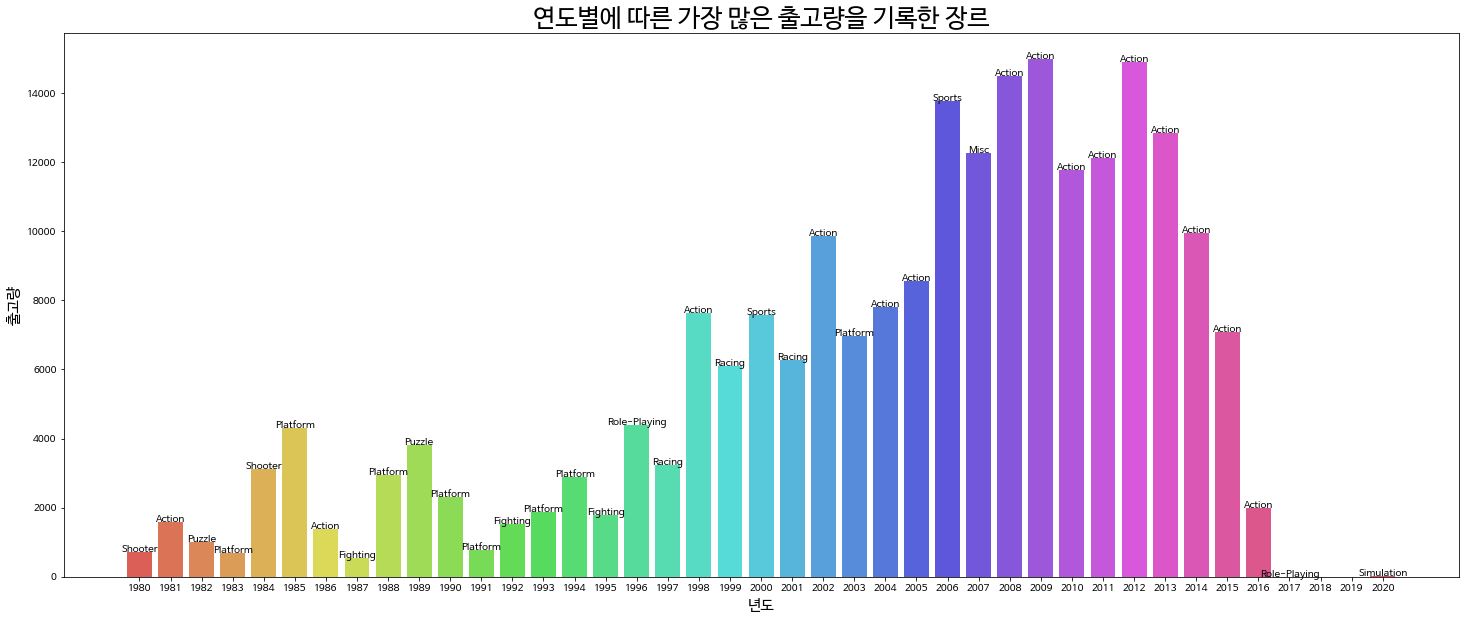

Action          15
Platform         8
Fighting         3
Racing           3
Role-Playing     2
Shooter          2
Sports           2
Puzzle           2
Simulation       1
Misc             1
Name: Genre, dtype: int64

In [6]:
year_max = year_gourp.groupby(['Year', 'Genre'])['Total_Sales'].sum().reset_index()
year_max = year_max.loc[year_max.groupby(['Year'])['Total_Sales'].idxmax()].reset_index(drop=True)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot()
colors = sns.color_palette('hls',len(year_max['Genre']))


plt.title('연도별에 따른 가장 많은 출고량을 기록한 장르', loc='center', fontsize=25)

plt.xticks(count)

plt.xlabel('년도', fontsize=15)
plt.ylabel('출고량', fontsize=15)

bars = plt.bar(year_max['Year'], year_max['Total_Sales'], color=colors)

for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height(), year_max['Genre'][i], ha='center')

plt.show()

year_max['Genre'].value_counts()


# 우선 짚고 넘어가야할 부분은 2017년 이후로는 표본 데이터가 너무 적다는 것입니다.
# 이는 게임 시장이 축소되고 있다는 뜻이며 게임에 투자할 비용을 신중히 생각해야 할 사항입니다.
# 그럼 그래프를 보면 알 수 있듯이 액션 게임과 플랫폼 게임이 주를 이루고 있음을 알 수 있습니다.
# 마지막으로 연도별로 가장 많이 출시된 장르 그래프를 확인하고 장르에 대한 결론을 내리겠습니다.

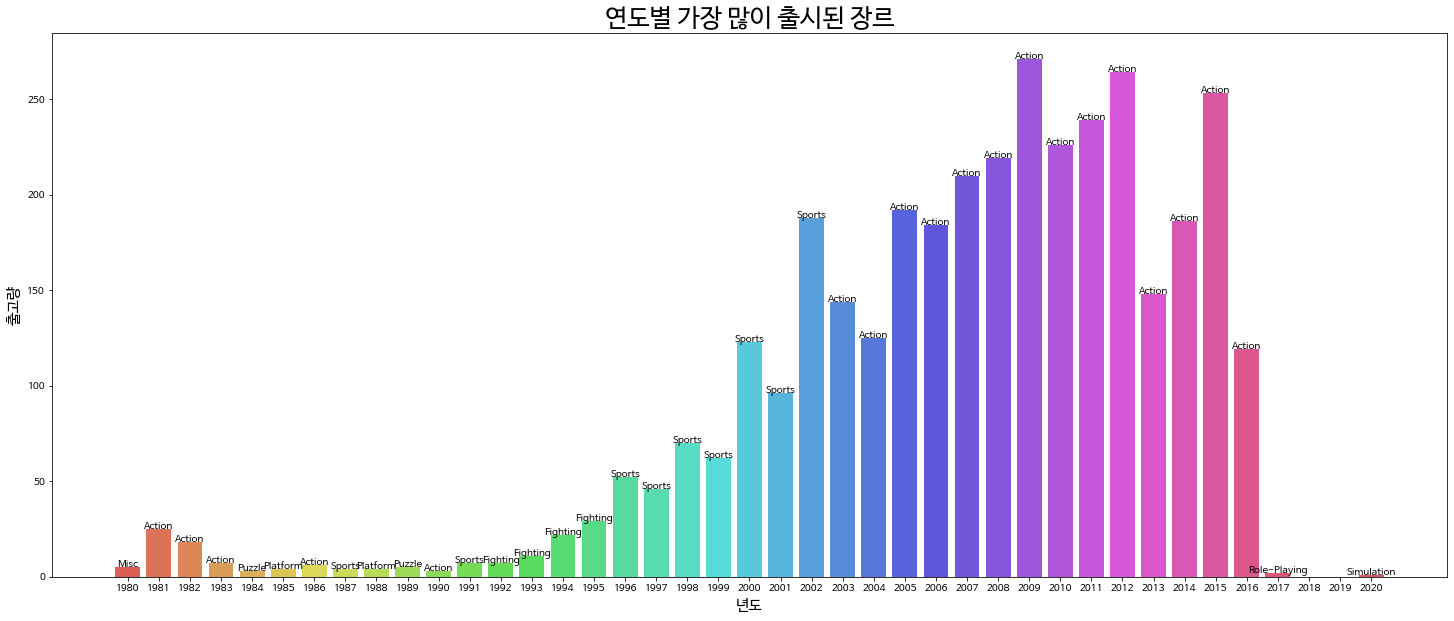

Action          19
Sports           9
Fighting         4
Platform         2
Puzzle           2
Role-Playing     1
Simulation       1
Misc             1
Name: Genre, dtype: int64

In [7]:
## 연도별 가장 많이 출시된 장르
year_genre = pd.concat([df_y, df_g], axis = 1)
year_genre['count'] = 1


year_genre = year_genre.groupby(['Year', 'Genre']).count().reset_index()

year_genre_max = year_genre.loc[year_genre.groupby(['Year'])['count'].idxmax()].reset_index(drop=True)
year_genre_max


fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot()
colors = sns.color_palette('hls',len(year_genre_max['Genre']))


plt.title('연도별 가장 많이 출시된 장르', loc='center', fontsize=25)

plt.xticks(count)

plt.xlabel('년도', fontsize=15)
plt.ylabel('출고량', fontsize=15)

bars = plt.bar(year_genre_max['Year'], year_genre_max['count'], color=colors)

for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height(), year_genre_max['Genre'][i], ha='center')

plt.show()

year_genre_max['Genre'].value_counts()


# 지금까지의 데이터를 정리해 보면 과거 2000년대 이전에는 플랫폼 게임의 출고량이 높고, 스포츠 게임이 많이 출시되었지만 2000년대 이후로는 액션 게임의 대세임을 알 수있습니다.

# 게임 시장이 활발히 활성화된 2000년대 부터 액션 게임이 인기임을 확인했으니 액션 게임을 만드는 것이 좋습니다.
# 다만 현재의 게임의 장르는 장르를 한 가지로 정의하기 힘든 다 장르를 추구하는 시대이기에 꾸준히 언급한 액션, 스포츠, 슈팅 게임은 참고하면 좋지만 어떤 장르이던지 액션이라는 요소를 기미한다면 최소한의 트렌드에 탑승한다고 볼 수 있습니다.

# 2000년대 이후로 게임 시장은 황금기를 맞이했으나 2010년대 이후로 점차 쇠퇴기를 맞이하고 있습니다. (게이머들이 게임을 멀리하는 이유를 찾아보기) 투자하는 비용에 대해 신중해야 할 필요성이 있습니다.

# 아래 그래프를 보면 1990년대 후반부터 2000년대 초에는 스포츠 게임의 강세였지만 2003년을 기점으로 액션의 비중이 압도적으로 높아졌다는 것을 알 수 있습니다. 이로써 우리는 액션 장르를 동반한 게임이 전세계적으로 인기라는 것을 알 수 있습니다.

# **3. 인기 게임 분석**

In [8]:
# 출고량이 높은 게임에 대한 분석 및 시각화 프로세스
# 출고량이 제일 높은 게임을 뽑아서 게임의 탄생 배경, 장르, 어떤 게임이 어떤 시장에 영향을 주었는지 분석

sales_high = df_EDA.sort_values(by='총합 출고량(단위:1만장)', ascending=False)
sales_high = sales_high.loc[sales_high['출시 년도'] > 2010]
sales_high = sales_high.loc[sales_high['총합 출고량(단위:1만장)'] > 1000]
sales_high


no_series = ['Call of Duty', 'Grand Theft Auto V']
test = '|'.join(no_series)

# 너무 많은 시리즈를 가진 콜 오브 듀티 시리즈와 3가지츼 플랫폼을 가진 GTA는 데이터의 정확성을 해치기에 이들을 제외하고 천만장 이상 출고량을 기록한 게임을 간추렸습니다.
sales_high_no_series = sales_high[sales_high['게임 이름'].str.contains(test, na=False) == False]
sales_high


# 아래는 최근 10년간 1천만장 이상의 출고량을 기록한 게임을 나타내는 표입니다. 눈으로도 볼 수 있듯이, 중복되는 퍼블리셔들이 굉장히 많음을 알 수 있습니다.

,게임 이름,플랫폼,출시 년도,장르,퍼블리셔(제작사),북미 출고량(단위:1만장),유럽 출고량(단위:1만장),일본 출고량(단위:1만장),기타 지역 출고량(단위:1만장),총합 출고량(단위:1만장)
1971,Pokemon X/Pokemon Y,3DS,2013,Misc,Nintendo,5170,405,434,79,6088
1629,Assassin's Creed III,PS3,2012,Action,Ubisoft,264,2560,16,113,2953
8010,Battlefield 3,X360,2011,Shooter,Electronic Arts,446,2130,6,69,2651
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,701,927,97,413,2138
9791,Call of Duty: Ghosts,PS4,2013,Shooter,Activision,1780,142,5,38,1965
6929,NBA 2K12,PS3,2011,Sports,Take-Two Interactive,1610,27,5,18,1660
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,963,531,6,138,1638
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,902,428,13,132,1475
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,577,581,35,231,1424
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,499,588,65,252,1404


In [ ]:
# 게임의 성공 비결은 성공 배경과 투자한 자본, 시간에 따른 게이머의 인식 변화 등의 여러 변수가 있지만 그 중에서도 공통적인 성공 비결은 A급 게임을 찍어낼 수 있는 퍼블리셔(제작사)가 있습니다.
# 아래 그래프는 제작사에 따른 출고량을 비교한 그래프입니다. 

pub_group = pd.concat([df['Publisher'], df_t], axis = 1)
pub_sales = pub_group.groupby('Publisher').sum().reset_index()
pub_sales = pub_sales.loc[pub_sales['Total_Sales'] > 17000]

colors = sns.color_palette('hls',len(pub_sales['Total_Sales']))

fig = plt.figure(figsize=(30, 10))

plt.title('퍼블리셔(제작사)에 따른 총합 출고량', loc='center', fontsize=25)

plt.xlabel('퍼블리셔(제작사)', fontsize=15)
plt.ylabel('출고량', fontsize=15)

plt.bar(pub_sales['Publisher'], pub_sales['Total_Sales'], color=colors)

plt.show()

#pub_sales.sort_values(by='Total_Sales' ,ascending=False)


# A급 게임을 찍어낼 수 있는 회사 소위 A급 퍼블리셔인 닌텐도, EA, 액티비전은 각각 19억, 11억, 7천만이라는 타 퍼블리셔에 비해 어마어마한 출고량을 기록했습니다.
# 사실상 닌텐도, EA, 액티비전이 제작하는 게임은 소위 게이머들 사이에서 '믿고 살 수 있는 게임사'라는 인식이 있다는 것을 알 수 있습니다.
# 하지만 이는 40년이나 되는 과거부터 지금까지의 출고량을 합친 값이므로 아래 그래프가 절대적인 값은 아니라고도 할 수 있습니다.
# 그렇다면 최근 10년간 각 퍼블리셔에 따른 출고량은 어떨까요?

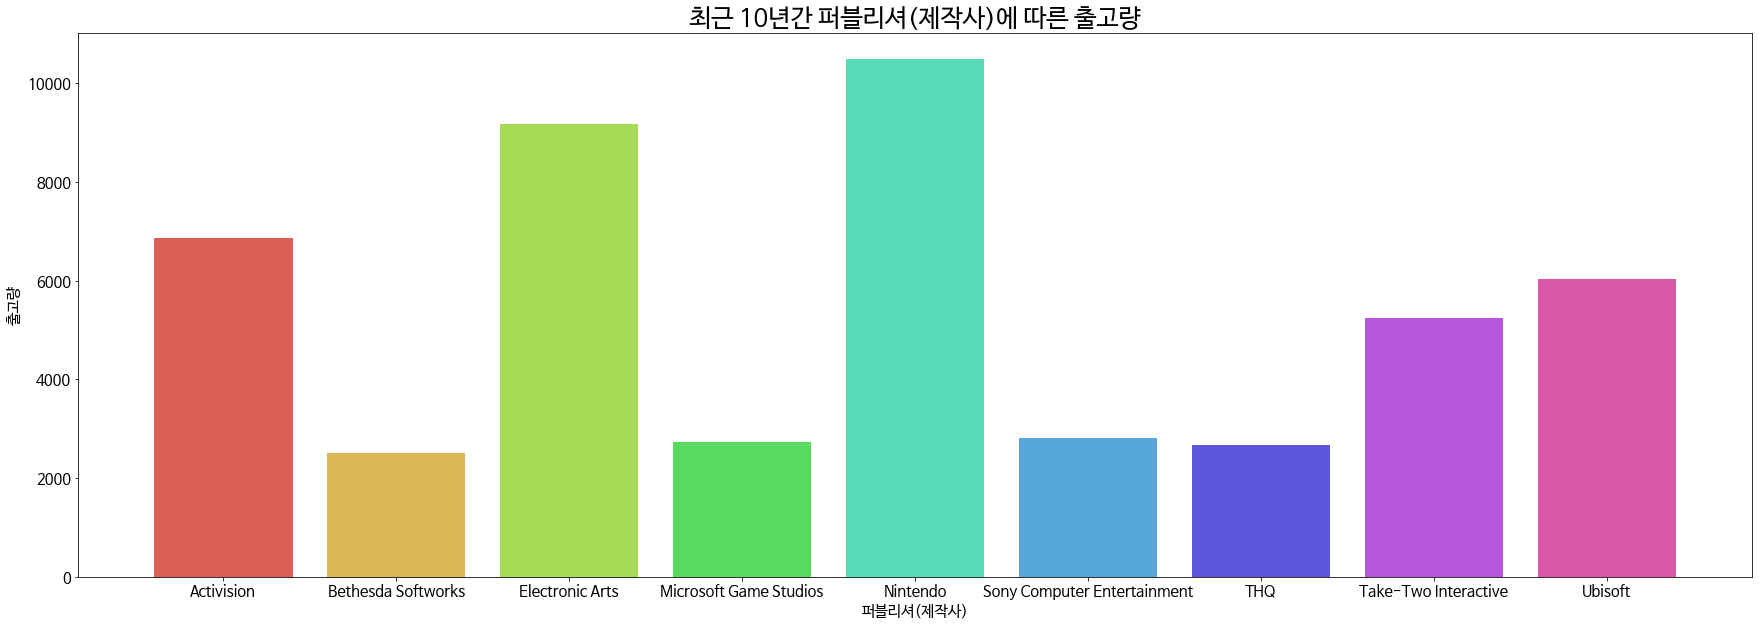

In [181]:
pub_year_group = pd.concat([df_y, df['Publisher'], df_t], axis = 1)
pub_year_group = pub_year_group.loc[pub_year_group['Year'] > 2010]

pub_year_sales = pub_year_group.groupby(['Year', 'Publisher'])['Total_Sales'].sum().reset_index()

pub_year_high = pub_year_sales.loc[pub_year_sales.groupby(['Publisher'])['Total_Sales'].idxmax()]
pub_year_high = pub_year_high.loc[pub_year_high['Total_Sales'] > 2500]
pub_year_high

colors = sns.color_palette('hls',len(pub_year_high['Total_Sales']))


fig = plt.figure(figsize=(30, 10))

plt.title('최근 10년간 퍼블리셔(제작사)에 따른 출고량', loc='center', fontsize=25)

plt.xlabel('퍼블리셔(제작사)', fontsize=15)
plt.ylabel('출고량', fontsize=15)

plt.bar(pub_year_high['Publisher'], pub_year_high['Total_Sales'], color=colors)

plt.show()
# 이는 사실상 닌텐도, EA, 액티비전이 제작하는 게임은 소위 게이머들 사이에서 '믿고 살 수 있는 게임사'라는 인식이 있다는 것을 알 수 있습니다. 그럼 이 인기 퍼블리셔들의 어떤 게임을 만들었는지 불러오겠습니다.

In [182]:
pub_list = ['Nintendo', 'Electronic Arts', 'Activision']
test = '|'.join(pub_list)
#df_EDA[df_EDA['퍼블리셔(제작사)'].str.contains(test)]


pub_pop = pd.concat([df_EDA.loc[:, '게임 이름':'출시 년도'], df_g, df_EDA['퍼블리셔(제작사)'], df_s, df_t], axis=1)
pub_pop = pub_pop[pub_pop['퍼블리셔(제작사)'].str.contains(test, na=False)]

pub_pop_high = pub_pop.loc[pub_pop['출시 년도'] > 2010]
pub_pop_high = pub_pop_high.loc[pub_pop['Total_Sales'] > 800]
pub_pop_high = pub_pop_high.rename(columns={"Genre":"장르", "NA_Sales":"북미 출고량", "EU_Sales":"유럽 출고량", "JP_Sales":"일본 출고량", "Other_Sales":"기타 지역 출고량", "Total_Sales":"총합 출고량"})
pub_pop_high = pub_pop_high.sort_values(by = '퍼블리셔(제작사)')
pub_pop_high

# 보기 쉽도록 최근 10년간 인기 퍼블리셔에서 출고량 8백만 장 이상을 기록한 게임을 나열해보았습니다.
# 첫째로 액티비전은 콜 오브 듀티 시리즈를 필두로 안정적인 출고량을 확보하고 있다는 것을 볼 수 있습니다. 이는 콜 오브 듀티 시리즈를 즐기는 마니아 층이 두텁다고도 볼 수 있습니다.
# 둘째로 EA는 유의미한 데이터를 찾아보기 힘든데, 유럽에서 대 히트를 친 배틀 필드가 슈팅 게임이라는 것만 알고 넘어가면 좋을 것 같습니다.
# 다음으로 닌텐도는 마리오와 포켓몬스터 시리즈를 통해 출고량을 어느정도 보장받고 있으며 무려 출고량 6천만 장을 기록한 포켓몬스터 X, Y는 당시 엄청난 인기를 끌었다고도 볼 수 있습니다.
# 이로써 알 수 있는 사실은 인기 퍼블리셔는 어느 정도 팬층이 확보되어 있는 게임 시리즈의 후속편을 출시하여 안정적인 수익을 취하는 방법을 택하고 있다는 것을 알 수 있습니다.

# 최근 10년간 인기 퍼블리셔에서 출고량 8백만 장 이상을 기록한 게임을 나열해보았습니다.
# 대부분이 기존 작품의 후속작을 계속해서 출시하고 있다는 것을 알 수 있습니다.
# 비교적 안정적인 수입을 원하신다면 이전 작품에 대한 계승작이나 후속작을 출시하는 것이 가장 안정적인 매출을 올릴수 있는 방법이라고 생각합니다.

,게임 이름,플랫폼,출시 년도,장르,퍼블리셔(제작사),북미 출고량,유럽 출고량,일본 출고량,기타 지역 출고량,총합 출고량
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,902,428,13,132,1475
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,499,588,65,252,1404
5604,Call of Duty: Ghosts,X360,2013,Shooter,Activision,672,263,4,82,1021
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,825,430,7,112,1374
6881,Call of Duty: Ghosts,PS3,2013,Shooter,Activision,409,373,38,138,958
7023,StarCraft II: Heart of the Swarm,PC,2013,Strategy,Activision,819,65,0,190,1074
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,554,582,49,162,1347
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,577,581,35,231,1424
9791,Call of Duty: Ghosts,PS4,2013,Shooter,Activision,1780,142,5,38,1965
8010,Battlefield 3,X360,2011,Shooter,Electronic Arts,446,2130,6,69,2651


In [ ]:
df['Platform'].value_counts()

# 플렛폼 분석인 인기 플랫폼만 간단히 분석
# 연도별 플렛폼의 빈도와 최고 출고량을 기록한 게임 에 따라 게임 시장에 어떤 영향력을 끼치는지 확인해보고
# 현재 게임 시장의 추세 장르는 앞에서 알아보았고 플랫폼만 2016년 이후 데이터는 제거하고

# 압도적인 콘솔 게임의 지분율이지만 PC 게임의 선호도가 어느 정도 인지 파악
# 아님 PC 게임의 선호도가 상승 중인지 확인

# 앞으로 3~5년 이후의 게임 시장은 어떨지 결론

In [ ]:
df_p = pd.Series(df['Platform'])


plat = pd.concat([df_y, df_EDA['퍼블리셔(제작사)'] ,df_p], axis = 1)
plat['count'] = 1

plat_group = plat.groupby(['Year', 'Platform', '퍼블리셔(제작사)']).sum().reset_index()

#plat_high = plat.loc[plat.groupby(['Year'])['Total_Sales'].idxmax()].reset_index(drop=True)



nin = ['Nintendo']
nin_plat = ['DS', 'Wii', 'WiiU', '3DS', 'GBA', 'NES', 'SNES', 'GC', 'N64']
test_nin = '|'.join(nin_plat)

# 연도별 닌텐도 시리즈
plat_group_nin = plat_group[plat_group['Platform'].str.contains(test_nin)]

plat_group_nin = plat_group_nin.groupby(['Year', 'Platform']).max().reset_index()
plat_group_nin_high = plat_group_nin.loc[plat_group_nin.groupby(['Year'])['count'].idxmax()].reset_index(drop=True)

"""
plat_new = plat.loc[plat['Year'] > 2006]
plat_new = plat_new.loc[plat_new['Year'] < 2017]

plat_new_group = plat_new.groupby(['Year', 'Platform']).sum().reset_index()
plat_new_max = plat_new_group.loc[plat_new_group['count'] > 40]
plat_new_max"""



fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot()
colors = sns.color_palette('hls',len(plat_group_nin_high['Year']))

count = []
for i in range(38):
  x = i + 1983
  count.append(x)

plt.title('연도별 닌텐도 인기 플랫폼 출고량', loc='center', fontsize=25)

plt.xticks(count)

plt.xlabel('년도', fontsize=15)
plt.ylabel('출고량', fontsize=15)

bars = plt.bar(plat_group_nin_high['Year'], plat_group_nin_high['count'], color=colors)

for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height(), plat_group_nin_high['Platform'][i], ha='center')

plt.show()


# 5~6년 사이 간격으로 세로운 플렛폼을 출시한다는 사실을 알 수 있습니다.

In [ ]:


ps_plat = ['PS2', 'PS3', 'PS4', 'PSV', 'PSP', 'PS']
test_ps = '|'.join(ps_plat)


# 연도별 플스 시리즈
plat_group_ps = plat_group[plat_group['Platform'].str.contains(test_ps)]

plat_group_ps_high = plat_group_ps.groupby(['Year', 'Platform']).max().reset_index()
plat_group_ps_high = plat_group_ps_high.loc[plat_group_ps_high.groupby(['Year'])['count'].idxmax()].reset_index(drop=True)
plat_group_ps_high


fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot()
colors = sns.color_palette('hls',len(plat_group_ps_high['Year']))

count = []
for i in range(41):
  x = i + 1980
  count.append(x)

plt.title('연도별 플스 인기 플랫폼 출고량', loc='center', fontsize=25)

plt.xticks(count)

plt.xlabel('년도', fontsize=15)
plt.ylabel('출고량', fontsize=15)

bars = plt.bar(plat_group_ps_high['Year'], plat_group_ps_high['count'], color=colors)

for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height(), plat_group_ps_high['Platform'][i], ha='center')

plt.show()



# 다소 불안한 그래프지만 플스 3의 점유율이 높다는 것을 알 수 있습니다.

In [ ]:

# 연도별 xbox 시리즈

xb_plat = ['X360', 'XB', 'XOne']
test_xb = '|'.join(xb_plat)


plat_group_xb = plat_group[plat_group['Platform'].str.contains(test_xb)]

plat_group_xb_high = plat_group_xb.groupby(['Year', 'Platform']).max().reset_index()
plat_group_xb_high = plat_group_xb_high.loc[plat_group_xb_high.groupby(['Year'])['count'].idxmax()].reset_index(drop=True)
plat_group_xb_high


fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot()
colors = sns.color_palette('hls',len(plat_group_xb_high['Year']))

count = []
for i in range(41):
  x = i + 1980
  count.append(x)

plt.title('연도별 xbox 인기 플랫폼 출고량', loc='center', fontsize=25)

plt.xticks(count)

plt.xlabel('년도', fontsize=15)
plt.ylabel('출고량', fontsize=15)

bars = plt.bar(plat_group_xb_high['Year'], plat_group_xb_high['count'], color=colors)

for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height(), plat_group_xb_high['Platform'][i], ha='center')

plt.show()

# 엑스박스는 모든 플랫폼이 연동이 가능하기 때문에 개발 과정에서는 큰 문제가 없습니다.

# **4. 게임 시장 전망 예측**



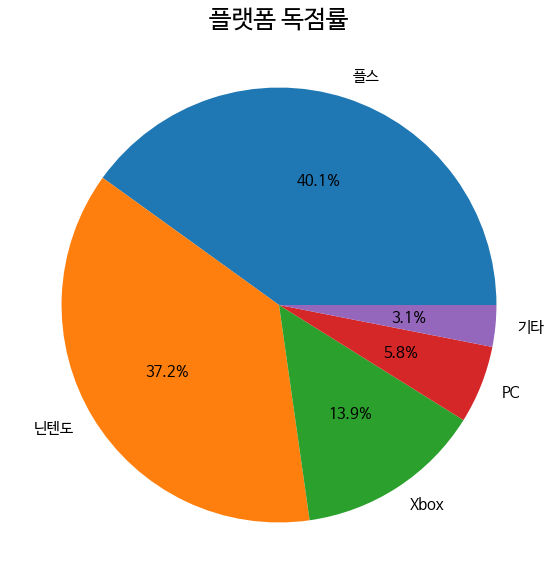

In [143]:

plat_ps = len(plat[plat['Platform'].str.contains(test_ps)])
plat_nin = len(plat[plat['Platform'].str.contains(test_nin)])
plat_xb = len(plat[plat['Platform'].str.contains(test_xb)])
plat_other = len(plat) - (plat_ps + plat_nin + plat_xb + plat_PC)

plat_PC = len(plat[plat['Platform'].str.contains('PC')])


plt.figure(figsize=(10,10))

plt.title('플랫폼 독점률', loc='center', fontsize=25)

plt.rcParams['font.size'] = 15

ratio = [plat_ps, plat_nin, plat_xb, plat_PC, plat_other]
labels = ['플스', '닌텐도', 'Xbox', 'PC', '기타']

plt.rc('axes', labelsize=20)

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()


# 해외 게임 시장은 인터넷의 보급, 속도 문제 때문에 PC 게임 보다는 콘솔 게임을 선호하는 것을 알고 계실 것입니다. 그렇기에 아래 그래프와 같이 플랫폼의 선호도를 나타내는 것입니다.

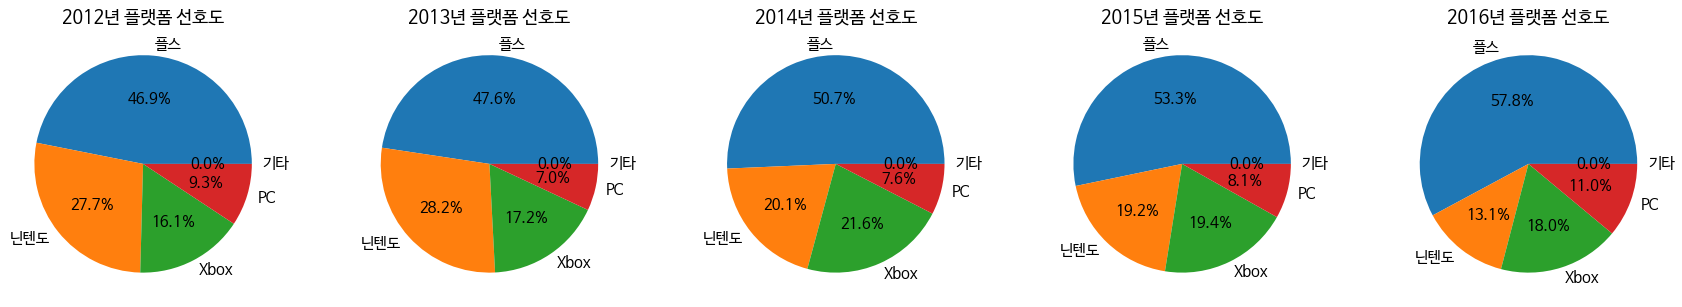

308

In [160]:

plat_ps = len(plat[plat['Platform'].str.contains(test_ps)])
plat_nin = len(plat[plat['Platform'].str.contains(test_nin)])
plat_xb = len(plat[plat['Platform'].str.contains(test_xb)])
plat_other = len(plat) - (plat_ps + plat_nin + plat_xb + plat_PC)

plat_PC = len(plat[plat['Platform'].str.contains('PC')])

plat_2012 = plat.loc[plat['Year'] == 2012]
plat_ps_2012 = len(plat_2012[plat_2012['Platform'].str.contains(test_ps)])
plat_nin_2012 = len(plat_2012[plat_2012['Platform'].str.contains(test_nin)])
plat_xb_2012 = len(plat_2012[plat_2012['Platform'].str.contains(test_xb)])
plat_PC_2012 = len(plat_2012[plat_2012['Platform'].str.contains('PC')])
plat_other_2012 = len(plat_2012) - (plat_ps_2012 + plat_nin_2012 + plat_xb_2012 + plat_PC_2012)


plat_2013 = plat.loc[plat['Year'] == 2013]
plat_ps_2013 = len(plat_2013[plat_2013['Platform'].str.contains(test_ps)])
plat_nin_2013 = len(plat_2013[plat_2013['Platform'].str.contains(test_nin)])
plat_xb_2013 = len(plat_2013[plat_2013['Platform'].str.contains(test_xb)])
plat_PC_2013 = len(plat_2013[plat_2013['Platform'].str.contains('PC')])
plat_other_2013 = len(plat_2013) - (plat_ps_2013 + plat_nin_2013 + plat_xb_2013 + plat_PC_2013)

plat_2014 = plat.loc[plat['Year'] == 2014]
plat_ps_2014 = len(plat_2014[plat_2014['Platform'].str.contains(test_ps)])
plat_nin_2014 = len(plat_2014[plat_2014['Platform'].str.contains(test_nin)])
plat_xb_2014 = len(plat_2014[plat_2014['Platform'].str.contains(test_xb)])
plat_PC_2014 = len(plat_2014[plat_2014['Platform'].str.contains('PC')])
plat_other_2014 = len(plat_2014) - (plat_ps_2014 + plat_nin_2014 + plat_xb_2014 + plat_PC_2014)

plat_2015 = plat.loc[plat['Year'] == 2015]
plat_ps_2015 = len(plat_2015[plat_2015['Platform'].str.contains(test_ps)])
plat_nin_2015 = len(plat_2015[plat_2015['Platform'].str.contains(test_nin)])
plat_xb_2015 = len(plat_2015[plat_2015['Platform'].str.contains(test_xb)])
plat_PC_2015 = len(plat_2015[plat_2015['Platform'].str.contains('PC')])
plat_other_2015 = len(plat_2015) - (plat_ps_2015 + plat_nin_2015 + plat_xb_2015 + plat_PC_2015)

plat_2016 = plat.loc[plat['Year'] == 2016]
plat_ps_2016 = len(plat_2016[plat_2016['Platform'].str.contains(test_ps)])
plat_nin_2016 = len(plat_2016[plat_2016['Platform'].str.contains(test_nin)])
plat_xb_2016 = len(plat_2016[plat_2016['Platform'].str.contains(test_xb)])
plat_PC_2016 = len(plat_2016[plat_2016['Platform'].str.contains('PC')])
plat_other_2016 = len(plat_2016) - (plat_ps_2016 + plat_nin_2016 + plat_xb_2016 + plat_PC_2016)


fig, ax = plt.subplots(1, 5, figsize=(30, 5))

ax[0].pie([plat_ps_2012, plat_nin_2012, plat_xb_2012, plat_PC_2012, plat_other_2012], labels=labels, autopct='%.1f%%')
ax[0].set_title("2012년 플랫폼 선호도")

ax[1].pie([plat_ps_2013, plat_nin_2013, plat_xb_2013, plat_PC_2013, plat_other_2013], labels=labels, autopct='%.1f%%')
ax[1].set_title("2013년 플랫폼 선호도")

ax[2].pie([plat_ps_2014, plat_nin_2014, plat_xb_2014, plat_PC_2014, plat_other_2014], labels=labels, autopct='%.1f%%')
ax[2].set_title("2014년 플랫폼 선호도")

ax[3].pie([plat_ps_2015, plat_nin_2015, plat_xb_2015, plat_PC_2015, plat_other_2015], labels=labels, autopct='%.1f%%')
ax[3].set_title("2015년 플랫폼 선호도")

ax[4].pie([plat_ps_2016, plat_nin_2016, plat_xb_2016, plat_PC_2016, plat_other_2016], labels=labels, autopct='%.1f%%')
ax[4].set_title("2016년 플랫폼 선호도")

plt.show()

plat_ps_2012

# 하지만 놀랍게도 2014년 부터 PC 게임의 수요가 늘고있음을 확인할 수 있습니다.
# 전세계적으로 인터넷 사용양은 매년 증가하며 그에 따른 인터넷 보급과 속도를 높이기 위해 큰 돈을 투자하고 있습니다.
# 이를 통해 알 수 있는 것은 가까운 미래에 해외 게임 시장도 우리가 밟아온 게임 역사와 같이 PC나 모바일 게임에 투자할 가능성이 존재한다는 것입니다.


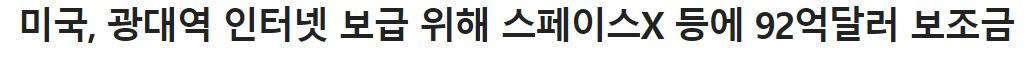

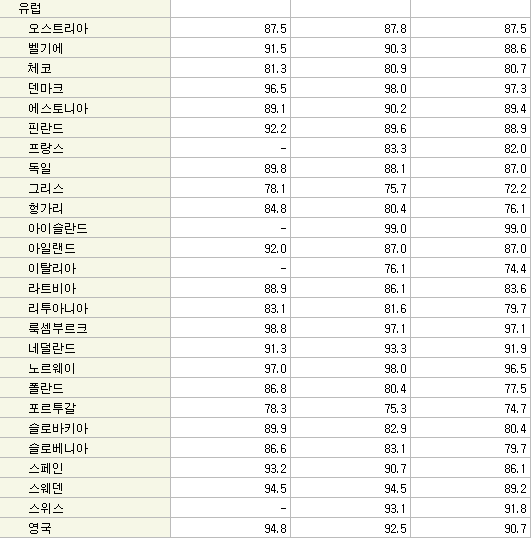

# **5. 결론**

위 내용을 종합적으로 따져봤을 때는 현재는 게임 시장이 암흑기이므로 게임 규모에 대해서 조심해야할 것입니다. 미래지향적으로 봤을 때 PC 게임은 콘솔 게임보다는 우세하기는 힘드나 개발 비용이 더 적고 충분한 잠재력을 갖추고 있으며 전체적인 게임 시장의 수익은 북미 시장에서 나오기 때문에 북미 시장의 선호하는 장르인 액션 장르를 겸비한 슈팅, 스포츠 장르의 게임이 가장 높은 수익을 낼 것이라고 생각합니다.